In [175]:
import os
import sys

import torch
from torch import nn, optim
from torch.nn import functional as FeatureAlphaDropout
import torch.nn as nn
sys.path.append(os.path.realpath('../'))
import numpy as np
import pickle as pkl
from datasets import make_dataloader
from bitrap.modeling import make_model
from bitrap.engine import build_engine

from bitrap.utils.logger import Logger
import logging
import argparse
from configs import cfg
from termcolor import colored 

from torch.utils.data import DataLoader
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


In [176]:
cfg.merge_from_file("../configs/bitrap_np_JAAD.yml")
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [177]:
model = make_model(cfg)
model = model.to(cfg.DEVICE)
checkpoint = "../" + cfg.CKPT_DIR + "best.pth"

if os.path.isfile(checkpoint):
    model.load_state_dict(torch.load(checkpoint))
    print(colored('Loaded checkpoint:{}'.format(checkpoint), 'blue', 'on_green'))
else:
    print(colored('The cfg.CKPT_DIR id not a file: {}'.format(checkpoint), 'green', 'on_red'))

Loaded checkpoint:../checkpoints/JAAD_checkpoints/goal_cvae_checkpoints/best.pth


In [178]:
images = [f"../data/JAAD/images/video_0005/000{i + 46}.png" for i in range(15)]
yolo = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)


dataloader = DataLoader(images, num_workers=1)
print(len(images))
_min = np.array([0,0,0,0])[None, :]
_max = np.array([1920, 1080, 1920, 1080])[None, :]

Using cache found in /home/waluigi/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2022-11-4 Python-3.10.6 torch-1.13.0 CUDA:0 (NVIDIA GeForce RTX 3090, 24246MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients
Adding AutoShape... 


15


In [179]:
def predict(model, input_x, cur_pos = None):
    gt_goal = None
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos
    batch_size, seg_len, _ = input_x.shape

    h_x = model.encoder(input_x, None)
    Z, KLD = model.gaussian_latent_net(h_x, input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM], None, z_mode=False)
    enc_h_and_z = torch.cat([h_x.unsqueeze(1).repeat(1, Z.shape[1], 1), Z], dim=-1)
    pred_goal = model.goal_decoder(enc_h_and_z)
    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x

    pred_goal = model.goal_decoder(enc_h_and_z)

    # dec_h = enc_h_and_z if model.cfg.DEC_WITH_Z else h_x
    pred_traj = model.pred_future_traj(h_x, pred_goal)
    cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM] if cur_pos is None else cur_pos.unsqueeze(1)
    pred_goal = pred_goal + cur_pos
    pred_traj = pred_traj + cur_pos.unsqueeze(1)

    return pred_traj, pred_goal



In [180]:
def get_image(imgs):
    results = yolo(imgs)
    data = []
    for j in range(len(results.pandas().xyxy)):
        df = results.pandas().xyxy[j]
        bounding_boxes_pedestrians = df.loc[df['class'] == 0]
        # TODO: FOR NOW, break statement exists so it only predicts one person... This will need to change
        for i, row in bounding_boxes_pedestrians.iterrows():
            bbox = np.array([[row['xmin'], row['ymin'], row['xmax'], row['ymax']]])
            bbox[..., [2, 3]] = bbox[..., [2, 3]] - bbox[..., [0, 1]]
            bbox[..., [0, 1]] += bbox[..., [2, 3]]/2
            
            

            # NOTE Normalize bbox
            # W, H  = all_resolutions[i][0]
            # _min comes from MIN_BBOX
            # _max comes from MAX_BBOX

            bbox = (bbox - _min) / (_max - _min)
            
            data.append(bbox[0])
            
    data = np.array(data)
    
    # max_val = np.max(np.abs(data))
    # min_val = np.min(data)



    return torch.FloatTensor(data)

In [181]:
%time
model.eval()

input_x = get_image(images)
input_x = input_x.to(cfg.DEVICE)
input_x = input_x.unsqueeze(0)
cur_pos = input_x[:, -1, :cfg.MODEL.DEC_OUTPUT_DIM]
pred_traj, pred_goal = predict(model, input_x, cur_pos=input_x[-1, :cfg.MODEL.DEC_OUTPUT_DIM])
pred_traj = pred_traj.detach().to('cpu').numpy()
pred_goal = pred_goal.detach().to('cpu').numpy()


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [182]:
pred_goal = pred_goal * (_max - _min) + _min
pred_traj = pred_traj * (_max - _min) + _min

In [197]:
pred_goal

array([[[     1139.1,      773.79,      104.51,      230.33],
        [     1061.5,      785.56,      119.39,      264.99],
        [     1207.3,      773.72,         104,      231.85],
        [     1493.4,      790.79,       126.7,      318.18],
        [     1232.8,      751.75,      68.977,      154.11],
        [     1263.9,      756.99,      91.677,      210.65],
        [     974.28,      770.23,      97.747,      210.82],
        [     1245.7,       782.3,      112.65,       259.9],
        [     1109.9,      807.12,      73.675,      150.95],
        [     1006.3,      769.44,       93.49,      201.19],
        [     1178.4,      747.56,      62.566,      137.99],
        [     1151.7,       754.3,       66.18,      150.16],
        [     1102.2,      777.36,      119.26,      256.51],
        [     1273.3,      763.75,      85.573,       199.2],
        [     1015.6,      779.15,      107.82,      229.75],
        [     1191.2,      790.78,      132.55,      300.31],
        

In [183]:
# pred_traj *= max_val

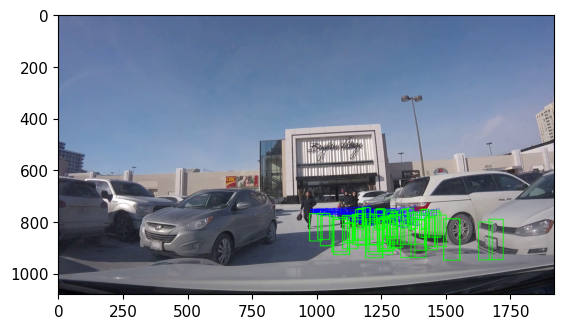

In [207]:
cv_image = cv2.imread(f"../data/JAAD/images/video_0005/00046.png")
for test in pred_traj:
    for j, traj in enumerate(test):
        for i, box in enumerate(traj):
            # rect = cv2.boundingRect(testArray)
            if i % 5 == 0 and i != 0:
                x, y, w, h = int(box[0]), int(box[1]), int(box[2] / 8), int(box[3] / 8)
                cv2.rectangle(cv_image, (x, y), (x + w, y + h), (255, 0, 0), 1)

# for goal in pred_goal:
#     for i, location in enumerate(goal):
        
#         x, y, w, h = int(location[0]), int(location[1]), int(location[2]), int(location[3])
#         cv2.rectangle(cv_image, (x, y), (int(x + w / 2) , int(y + h / 2)), (0, 255, 0), 2)

RGB_img = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
plt.imshow(RGB_img)
plt.show()